# BONUS

PURPOSE: To import the titles and salaries tables from postgres database and conduct analysis on avg salaries for each position. Also for running a check on employee number 499942.

METHODOLOGY:

        * Connect to postgres
        * Import desired tables into pandas
        * Merge tables
        * Group titles and calculate avg salary
        * Plot results
        * Search employee numbers

### CONNECT TO POSTGRES 

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt

# Import password
from postgres_password import password

from sqlalchemy import create_engine

# Parameters for connecting to postgres
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres'
POSTGRES_PASSWORD = password
POSTGRES_DBNAME = 'employees_db'

# String to contain parameters
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
    .format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, 
            port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))

# Create connection
engine = create_engine(postgres_str)
connection = engine.connect()

### STORE AND MERGE TABLES
    * Import employees, salaries, titles from database
    * Check length of tables to determine merge logic
    * Merge using emp_no

In [2]:
employees = pd.read_sql("SELECT * FROM employees", connection)
employees.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01
4,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12


In [3]:
salaries = pd.read_sql("SELECT * FROM salaries", connection)
salaries.head()

,emp_no,salary,from_date,to_date
0,10001,60117,1986-06-26,1987-06-26
1,10002,65828,1996-08-03,1997-08-03
2,10003,40006,1995-12-03,1996-12-02
3,10004,40054,1986-12-01,1987-12-01
4,10005,78228,1989-09-12,1990-09-12


In [4]:
titles = pd.read_sql("SELECT * FROM titles", connection)
titles.head()

,emp_no,title,from_date,to_date
0,10001,Senior Engineer,1986-06-26,9999-01-01
1,10002,Staff,1996-08-03,9999-01-01
2,10003,Senior Engineer,1995-12-03,9999-01-01
3,10004,Engineer,1986-12-01,1995-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01


In [5]:
# Check length to determine logic on how to merge
[len(employees), len(salaries), len(titles)]

[300024, 300024, 443308]

In [6]:
# First merge employees with salaries due to matching rows
emp_salary_merge = pd.merge(employees, salaries, on="emp_no")
emp_salary_merge.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,salary,from_date,to_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,60117,1986-06-26,1987-06-26
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,65828,1996-08-03,1997-08-03
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,40006,1995-12-03,1996-12-02
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,40054,1986-12-01,1987-12-01
4,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,78228,1989-09-12,1990-09-12


In [7]:
# Merge left the new table into titles since titles has more rows, ie. duplicate emp_nos with different titles
full_merge = pd.merge(titles, emp_salary_merge, on="emp_no", how="left")
full_merge.head()

,emp_no,title,from_date_x,to_date_x,birth_date,first_name,last_name,gender,hire_date,salary,from_date_y,to_date_y
0,10001,Senior Engineer,1986-06-26,9999-01-01,1953-09-02,Georgi,Facello,M,1986-06-26,60117,1986-06-26,1987-06-26
1,10002,Staff,1996-08-03,9999-01-01,1964-06-02,Bezalel,Simmel,F,1985-11-21,65828,1996-08-03,1997-08-03
2,10003,Senior Engineer,1995-12-03,9999-01-01,1959-12-03,Parto,Bamford,M,1986-08-28,40006,1995-12-03,1996-12-02
3,10004,Engineer,1986-12-01,1995-12-01,1954-05-01,Chirstian,Koblick,M,1986-12-01,40054,1986-12-01,1987-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01,1954-05-01,Chirstian,Koblick,M,1986-12-01,40054,1986-12-01,1987-12-01


## PLOT AVG SALARIES BY TITLE
    * Group the final merged table according to title
    * Find mean for each group and round to nearest dollar
    * Sort values from greatest to least
    * Plot

In [8]:
titles_grouped = full_merge.groupby("title")
# Average, round, sort
title_salaries = round(titles_grouped["salary"].mean(), 0).sort_values(ascending=False)
title_salaries

title
Senior Staff          58503.0
Staff                 58465.0
Manager               51531.0
Technique Leader      48581.0
Engineer              48540.0
Senior Engineer       48507.0
Assistant Engineer    48493.0
Name: salary, dtype: float64

In [9]:
# Verifying only 7 titles exist
full_merge["title"].value_counts()

Engineer              115003
Staff                 107391
Senior Engineer        97750
Senior Staff           92853
Technique Leader       15159
Assistant Engineer     15128
Manager                   24
Name: title, dtype: int64

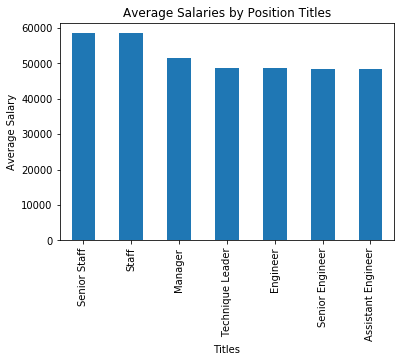

In [10]:
title_salaries.plot.bar()
plt.xlabel("Titles")
plt.ylabel("Average Salary")
plt.title("Average Salaries by Position Titles")
plt.savefig("salaries.png", bbox_inches="tight")

## SEARCH EMPLOYEE NUMBER 499942
    * Set index on full_merge table to emp_no
    * Use .loc to search and retrieve data

In [11]:
employees_indexed = full_merge.set_index("emp_no")
employees_indexed.loc[499942]

title          Technique Leader
from_date_x          1998-03-28
to_date_x            9999-01-01
birth_date           1963-01-10
first_name                April
last_name              Foolsday
gender                        F
hire_date            1997-02-10
salary                    40000
from_date_y          1998-03-28
to_date_y            1999-03-28
Name: 499942, dtype: object